In [1]:
import pandas as pd
import glob
import talib
import datetime
import numpy as np
# import pandas_ta as ta
from scipy import stats
import matplotlib.pyplot as plt
import six
from itertools import combinations
import multiprocessing


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
pd.set_option('max_colwidth', -1)

In [2]:
class Indicator:
    
    df_expiry = pd.DataFrame()
    
    frequency = {'5min':'5Min', '60min':'H', 'daily':'D', 'weekly':'W', 'monthly':'M', 'quarterly':'Q', 'yearly':'A', 'weekly-thursday': 'W-THU'}
    resampling_dict = {'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum', 'time':'last', 'date':'last'}
    renaming_dict = {'open':'open', 'high':'high', 'low':'low', 'close':'close', 'volume':'volume', 'time':'time', 'date':'date'}
    
    @staticmethod
    def resample_df(df, period, expiry=False, opex=False):
        
        df.set_index('datetime', inplace=True)
        
        if expiry:
            resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                           'close': 'last', 'date': 'first', 'time': 'first', 'expiry_date':'first'}
        elif opex:
            resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                           'close': 'last', 'date': 'first', 'time': 'first', 'opex':'first'}
        else:
            resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                           'close': 'last', 'date': 'first', 'time': 'first'}

        df = df.resample(period).apply(resampling_dict)
        df = df.dropna()
        df = df.reset_index()
        
        return df
    
    @staticmethod
    def get_unique_time_list(df, period):
        
        if period == '1H':
            times_list = [datetime.time(9, 15),datetime.time(10, 0),datetime.time(11, 0),datetime.time(12, 0),datetime.time(13, 0),datetime.time(14, 0),datetime.time(15, 0)]
        elif period == '5min':
            times_list = [i for i in df['time'].unique() if i.minute%5 == 0 and i<datetime.time(15,25)]
        
        return times_list
    
    @staticmethod
    def get_A_level(df, params):
        
        # df=None, atr_lookback=14, premium_multiplier=0.2, timeframe='daily', open_range='5min'
        timeframe = params[0]
        atr_lookback = params[1]
        premium_multiplier = params[2]
        open_range = params[3]
        
        df_with_prem = get_prem(df=df, timeframe=timeframe, atr_lookback=atr_lookback, premium_multiplier=premium_multiplier)
        df[f'{timeframe}_atr'] = df_with_prem[f'{timeframe}_atr']
        df[f'{timeframe}_atr'] = df[f'{timeframe}_atr'].shift()
        df[f'{timeframe}_atr'].ffill(inplace = True)
        df[f'{timeframe}_prem'] = df_with_prem[f'{timeframe}_prem']
        open_range_bars = int(open_range.split('min')[0])    
        df[f'{timeframe}_prem'] = df[f'{timeframe}_prem'].shift(open_range_bars)
        df['bar_position'] = get_bar_position(df=df, timeframe=timeframe)
        df[f'{timeframe}_or_high'] = get_or_range(df=df, column='high', or_bars=open_range_bars)
        df[f'{timeframe}_or_low'] = get_or_range(df=df, column='low', or_bars=open_range_bars)
    #     print(df.tail(100))
        df[f'{timeframe}_aup'] = df[f'{timeframe}_or_high'] + df[f'{timeframe}_prem']
        df[f'{timeframe}_adown'] = df[f'{timeframe}_or_low'] - df[f'{timeframe}_prem']

        df[f'{timeframe}_aup'].ffill(inplace = True)
        df[f'{timeframe}_adown'].ffill(inplace = True)

        df[f'{timeframe}_aup'] = np.where(df['bar_position'] <= open_range_bars, np.nan, df[f'{timeframe}_aup'])
        df[f'{timeframe}_adown'] = np.where(df['bar_position'] <= open_range_bars, np.nan, df[f'{timeframe}_adown'])

        df = df.drop(['bar_position'], axis = 1)
        if timeframe == 'weekly':
            df = df.drop('week', axis = 1)
        if timeframe == 'monthly':
            df = df.drop('month_count', axis = 1)
        return df
    
    
    @staticmethod
    def rsi(df, params):
        
        df_rsi = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        lookback = params[1]
        lower_bound = params[2]
        upper_bound = params[3]
        
        df_rsi = Indicator.resample_df(df_rsi, resample_period)
    
        df_rsi[f'RSI_{resample_period}_{lookback}'] = talib.RSI(df_rsi['close'], timeperiod=lookback)

        df_rsi[f'RSI_{resample_period}_{lookback}'] = df_rsi[f'RSI_{resample_period}_{lookback}'].shift()

        if resample_period == 'D':
            df = df.merge(
                df_rsi[['date', f'RSI_{resample_period}_{lookback}']], how='left', on='date')
            df = df.ffill()
        else:
            df = df.merge(
                df_rsi[['datetime', f'RSI_{resample_period}_{lookback}']], how='left', on='datetime')
            df = df.ffill()

        condition_list = [(df[f'RSI_{resample_period}_{lookback}'] >= upper_bound), 
                          ((df[f'RSI_{resample_period}_{lookback}'] < upper_bound) & (df[f'RSI_{resample_period}_{lookback}'] > lower_bound)), 
                          (df[f'RSI_{resample_period}_{lookback}'] <= lower_bound)]

        choice_list = [f'RSI_{resample_period}_{lookback}>{upper_bound}', 
                       f'{lower_bound}<RSI_{resample_period}_{lookback}<{upper_bound}', 
                       f'RSI_{resample_period}_{lookback}<{lower_bound}']

        df[f'RSI_{resample_period}_{lookback}_{lower_bound}_{upper_bound}_conditions'] = np.select(condition_list, choice_list)

        return df
    
    @staticmethod
    def get_gap(df, params):
        
        gap_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        print(params)
        resample_period = params[0]
        
        gap_df = Indicator.resample_df(gap_df, resample_period)
        
        condition_list = [(gap_df['open'] >= gap_df['close'].shift()) & (gap_df['open'] <= gap_df['high'].shift()), 
                          (gap_df['open'] < gap_df['close'].shift()) & (gap_df['open'] >= gap_df['low'].shift()), 
                          (gap_df['open'] > gap_df['high'].shift()), 
                          (gap_df['open'] < gap_df['low'].shift())]

        choice_list = [f'gap-up', f'gap-down', f'full-gap-up', f'full-gap-down']
        
        gap_df['gap_conditions'] = np.select(condition_list, choice_list)
        
        df = df.merge(gap_df[['date', 'gap_conditions']], how='left', on='date')
        df = df.ffill()
        
        return df
    
    @staticmethod
    def log_volatility(df, params, factor):
        
        resample_period = params[0]
        lookback = params[1]
        annualize = factor[resample_period]*252
        
        vol_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        vol_df = Indicator.resample_df(vol_df, resample_period)
        
        vol_df[f'log_vol_{resample_period}_{lookback}'] = np.log(vol_df['close']/vol_df['close'].shift()).rolling(window = lookback).std() * math.sqrt(annualize) * 100
        
        vol_df[f'log_vol_{resample_period}_{lookback}'] = vol_df[f'log_vol_{resample_period}_{lookback}'].shift()
        
        if resample_period == 'D':
            df = df.merge(
                df_rsi[['date', f'log_vol_{resample_period}_{lookback}']], how='left', on='date')
            df = df.ffill()
        else:
            df = df.merge(
                df_rsi[['datetime', f'log_vol_{resample_period}_{lookback}']], how='left', on='datetime')
            df = df.ffill()
            
        return df
    
    #vol_conditions['name':name, 'func_name':Indicators.log_volatility, 'params':[x, y, x], 'annualizing_factor_dict':{'5m':no_of_bars, '1H':no_of_bars..}]
    @staticmethod
    def vol_compare(df, params):
        
        vol_conditions1 = params['fast']
        df = vol_conditions1['func_name'](df, vol_conditions1['params'], vol_conditions1['annualizing_factor'])
        
        vol_conditions2 = params['slow']
        df = vol_conditions2['func_name'](df, vol_conditions2['params'], vol_conditions1['annualizing_factor'])
        
        resample_period1 = vol_conditions1['params'][0]
        lookback1 = vol_conditions1['params'][1]       
        resample_period2 = vol_conditions2['params'][0]
        lookback2 = vol_conditions2['params'][1]
        
        conditions = [df[f'log_vol_{resample_period1}_{lookback1}'] >= df[f'log_vol_{resample_period2}_{lookback2}'],
                      df[f'log_vol_{resample_period1}_{lookback1}'] < df[f'log_vol_{resample_period2}_{lookback2}']]
        
        choices = [f'log_vol_{resample_period1}_{lookback1}>=log_vol_{resample_period2}_{lookback2}',
                   f'log_vol_{resample_period1}_{lookback1}<log_vol_{resample_period2}_{lookback2}']
        
        
        df['vol_condition'] = np.select(conditions, choices)
        
        # number of period fast vol below slow vol and number of days fast above slow
        df['days_vol_fast_below_slow'] = np.where(df['vol_condition'] == f'log_vol_{resample_period1}_{lookback1}<log_vol_{resample_period2}_{lookback2}', 1, 0)
        
        for _ in range(1, len(df)):
            df['days_vol_fast_below_slow'].iloc[_] += df['days_vol_fast_below_slow'].iloc[_-1]
            
            if df['days_vol_fast_below_slow'].iloc[_] == df['days_vol_fast_below_slow'].iloc[_-1]:
                df['days_vol_fast_below_slow'].iloc[_] = 0
        
        # number of period fast vol below slow vol and number of days fast above slow
        df['days_vol_fast_above_slow'] = np.where(df['vol_condition'] == f'log_vol_{resample_period1}_{lookback1}>=log_vol_{resample_period2}_{lookback2}', 1, 0)
        
        for _ in range(1, len(df)):
            df['days_vol_fast_above_slow'].iloc[_] += df['days_vol_fast_above_slow'].iloc[_-1]
            
            if df['days_vol_fast_above_slow'].iloc[_] == df['days_vol_fast_above_slow'].iloc[_-1]:
                df['days_vol_fast_above_slow'].iloc[_] = 0
        
        return df
    
    @staticmethod
    def up_down(df, params):
        
        resample_period = params[0]
        lookback = params[1]
        
        up_down_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        up_down_df = Indicator.resample_df(up_down_df, resample_period)
        
        up_down_df['0_prevpattern'] = np.where(up_down_df['close'] >= up_down_df['close'].shift(), 'U', 'D')
        column_list = []
        for _ in range(0, lookback):
            up_down_df[f'{lookback - _}_prevpattern'] = up_down_df['0_prevpattern'].shift(lookback - _)
            column_list.append(f'{lookback - _}_prevpattern')
        
        up_down_df[f'{lookback}_day_pattern'] = up_down_df[column_list].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
        up_down_df = up_down_df.drop(column_list, axis = 1)
        
        df = df.merge(
                up_down_df[['date', f'{lookback}_day_pattern']], how='left', on='date')
        return df
    
    @staticmethod
    def day_of_week(df):
        
        df['day_of_week'] = df['date'].apply(lambda x: x.strftime("%A"))
        
        return df
    
    @staticmethod
    def max_min_move(df, params):
        
        max_min_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        lookback = params[1]
        
        max_min_df = Indicator.resample_df(max_min_df, resample_period)
        
        max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'] = np.where(abs(np.log(max_min_df['close']/max_min_df['close'].shift())).rolling(window = lookback).max() == abs(np.log(max_min_df['close']/max_min_df['close'].shift())), 'max', '-')
        
        max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'] = np.where((max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'] == 'max') &
                                                        (np.log(max_min_df['close']/max_min_df['close'].shift()) < 0),
                                                        f'min-move_{resample_period}_{lookback}',
                                                        np.where((max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'] == 'max') & (np.log(max_min_df['close']/max_min_df['close'].shift()) > 0),
                                                        f'max-move_{resample_period}_{lookback}', '-'))
        
        max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'] = max_min_df[f'max_min_move_{resample_period}_{lookback}_periods_conditions'].shift()
        
        if resample_period == 'D':
            df = df.merge(
                max_min_df[['date', f'max_min_move_{resample_period}_{lookback}_periods_conditions']], how='left', on='date')
            df = df.ffill()
        else:
            df = df.merge(
                max_min_df[['datetime', f'max_min_move_{resample_period}_{lookback}_periods_conditions']], how='left', on='datetime')
            df = df.ffill()
        
        return df
    
    @staticmethod
    def max_min_move_no_shift(df, params):
        
        max_min_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        lookback = params[1]
        
        max_min_df = Indicator.resample_df(max_min_df, resample_period)
        
        max_min_df[f'max_min_move_{resample_period}_{period}_periods'] = np.where(abs(np.log(max_min_df['close']/max_min_df['close'].shift())).rolling(window = lookback).max() == abs(np.log(max_min_df['close']/max_min_df['close'].shift())), 'max', '-')
        
        max_min_df[f'max_min_move_{resample_period}_{period}_periods'] = np.where((max_min_df[f'max_min_move_{period}_days'] == 'max') &
                                                        (np.log(max_min_df['close']/max_min_df['close'].shift()) < 0),
                                                        f'min-move_{resample_period}_{lookback}',
                                                        np.where((max_min_df[f'max_min_move_{period}_days'] == 'max') & (np.log(max_min_df['close']/max_min_df['close'].shift()) > 0),
                                                        f'max-move_{resample_period}_{lookback}', '-'))

        
        if resample_period == 'D':
            df = df.merge(
                max_min_df[['date', f'max_min_move_{resample_period}_{period}_periods']], how='left', on='date')
            df = df.ffill()
        else:
            df = df.merge(
                max_min_df[['datetime', f'max_min_move_{resample_period}_{period}_periods']], how='left', on='datetime')
            df = df.ffill()
        
        return df
    
    @staticmethod
    def max_min_move_crosssection(df, params):
        
        max_min_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        lookback = params[1]
        
        max_min_df = Indicator.resample_df(max_min_df, resample_period)
        
        if resample_period != 'D':
            
            times_list = Indicator.get_time_list(max_min_df, resample_period)

            for time in times_list:
                temp = max_min_df[max_min_df['time']==time].copy()

                temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] = np.where(abs(np.log(temp['close']/temp['open'])).rolling(window = lookback).max() == abs(np.log(temp['close']/temp['open'])), 'max', '')
                temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] = np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] == 'max') & (np.log(temp['close']/temp['open']) < 0), f'min-move_{resample_period}_{lookback}', np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] == 'max') & (np.log(temp['close']/temp['open']) > 0), f'max-move_{resample_period}_{lookback}', ''))

                max_min_df = max_min_df.merge(temp[['datetime', f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}']], on='datetime', how='left')
                max_min_df.fillna('', inplace=True)

            column_list = [i for i in max_min_df.columns if i.split(resample_period)[0] == 'max_min_move_']
            max_min_df[f'max_min_{resample_period}_{lookback}'] = max_min_df[column_list].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
            max_min_df = max_min_df.drop(column_list, axis = 1)
            max_min_df[f'max_min_{resample_period}_{lookback}'] = np.where(max_min_df[f'max_min_{resample_period}_{lookback}'] == '', '-', max_min_df[f'max_min_{resample_period}_{lookback}'])
            
            max_min_df[f'max_min_{resample_period}_{lookback}'] = max_min_df[f'max_min_{resample_period}_{lookback}'].shift()
            
            df = df.merge(
                max_min_df[['datetime', f'max_min_{resample_period}_{lookback}']], how='left', on='datetime')
            df = df.ffill()
            
        else:
            max_min_df = Indicator.day_of_week(max_min_df)
            days_list = max_min_df['day_of_week'].unique()
            days_list = [i for i in max_min_df['day_of_week'].unique() if i not in ['Saturday', 'Sunday']]
            
            max_min_df['day_move'] = np.log(max_min_df['close']/max_min_df['close'].shift())
            
            for day in days_list:
                temp = max_min_df[max_min_df['day_of_week']==day].copy()
                
                temp[f'max_min_move_{resample_period}_{lookback}_periods_{day}'] = np.where(abs(temp['day_move']) == abs(temp['day_move']).rolling(window=lookback).max(), 'max', '')
                temp[f'max_min_move_{resample_period}_{lookback}_periods_{day}'] = np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods']=='max') & (temp['day_move'] > 0), f'max-move_{resample_period}_{lookback}_{day}',
                                                                                     np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods']=='max') & (temp['day_move'] < 0), f'min-move_{resample_period}_{lookback}_{day}', ''))
                
                max_min_df = max_min_df.merge(temp[['date', f'max_min_move_{resample_period}_{lookback}_periods_{day}']], on='date', how='left')
            
            column_list = [i for i in max_min_df.columns if i.split(resample_period)[0] == 'max_min_move_']
            max_min_df[f'max_min_{resample_period}_{lookback}'] = max_min_df[column_list].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
            max_min_df = max_min_df.drop(column_list, axis = 1)
            max_min_df[f'max_min_{resample_period}_{lookback}'] = np.where(max_min_df[f'max_min_{resample_period}_{lookback}'] == '', '-', max_min_df[f'max_min_{resample_period}_{lookback}'])
            
            max_min_df[f'max_min_{resample_period}_{lookback}'] = max_min_df[f'max_min_{resample_period}_{lookback}'].shift()
            
            df = df.merge(
                max_min_df[['date', f'max_min_{resample_period}_{lookback}']], how='left', on='date')
        
        return df
    
    @staticmethod
    def get_opex_column(df):
        
        df_expiry = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close', 'expiry_date']].copy()
        df_expiry = Indicator.resample_df(df_expiry, 'D', expiry='True')
        
        conditions = [df_expiry['date'] == df_expiry['expiry_date'],
         df_expiry['date'].shift(-1) == df_expiry['expiry_date'],
         (df_expiry['date'].shift(-2) == df_expiry['expiry_date']),
         (df_expiry['date'].shift(-3) == df_expiry['expiry_date']),
         (df_expiry['date'].shift(-4) == df_expiry['expiry_date'])]

        choices = ['opex', 'opex1', 'opex2', 'opex3', 'opex4']

        df_expiry['opex'] = np.select(conditions, choices)
        
        df = df.merge(df_expiry[['date','opex']], on='date', how='left')
        df = df.ffill()
        return df
    
    @staticmethod
    def first_max_min_move_expiry(df, params):
        
        df = Indicator.get_opex_column(df)
        
        resample_period = params[0]
        lookback = params[1]
        
        max_min_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close', 'opex']].copy()     
        max_min_df = Indicator.resample_df(max_min_df, resample_period, opex=True)
        
        max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] = np.where(abs(np.log(max_min_df['close']/max_min_df['close'].shift())).rolling(window = lookback).max() == abs(np.log(max_min_df['close']/max_min_df['close'].shift())), 'max', '-')
        
        max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] = np.where((max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == 'max') &
                                                        (np.log(max_min_df['close']/max_min_df['close'].shift()) < 0),
                                                        f'min-move_{resample_period}_{lookback}',
                                                        np.where((max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == 'max') & (np.log(max_min_df['close']/max_min_df['close'].shift()) > 0),
                                                        f'max-move_{resample_period}_{lookback}', '-'))
        
        if resample_period != 'D':
            max_min_df['first_min_move'] = np.where((max_min_df['opex'].shift()=='opex')&(max_min_df['opex']!='opex'), 1, None)
            max_min_df['first_min_move'] = np.where(max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'min-move_{resample_period}_{lookback}', f'min-move_{resample_period}_{lookback}', max_min_df['first_min_move'])
            max_min_df.loc[:,'first_min_move'] = max_min_df.loc[:,'first_min_move'].ffill()
            max_min_df['first_min_move'] = np.where((max_min_df['first_min_move'].shift()==1)&(max_min_df['first_min_move']==f'min-move_{resample_period}_{lookback}'),f'min-move_{resample_period}_{lookback}','')
            
            max_min_df['first_max_move'] = np.where((max_min_df['opex'].shift()=='opex')&(max_min_df['opex']!='opex'), 1, None)
            max_min_df['first_max_move'] = np.where(max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'max-move_{resample_period}_{lookback}', f'max-move_{resample_period}_{lookback}', max_min_df['first_max_move'])
            max_min_df.loc[:,'first_max_move'] = max_min_df.loc[:,'first_max_move'].ffill()
            max_min_df['first_max_move'] = np.where((max_min_df['first_max_move'].shift()==1)&(max_min_df['first_max_move']==f'max-move_{resample_period}_{lookback}'),f'max-move_{resample_period}_{lookback}','')
            
            max_min_df[f'first_max_min_move_{resample_period}_{lookback}_periods_conditions'] = max_min_df[['first_min_move', 'first_max_move']].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
        else:
            max_min_df['first_min_move'] = np.where((max_min_df['opex'].shift()=='opex')&(max_min_df['opex']!='opex'), 1, None)
            max_min_df['first_min_move'] = np.where(max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'min-move_{resample_period}_{lookback}', f'min-move_{resample_period}_{lookback}', max_min_df['first_min_move'])
            max_min_df.loc[:,'first_min_move'] = max_min_df.loc[:,'first_min_move'].ffill()
            conditions = [(max_min_df['first_min_move'] == f'min-move_{resample_period}_{lookback}') & (max_min_df['opex'].shift()=='opex'),
                          (max_min_df['first_min_move'] == f'min-move_{resample_period}_{lookback}') & (max_min_df['first_min_move'].shift()==1)]
            choices = [f'min-move_{resample_period}_{lookback}', f'min-move_{resample_period}_{lookback}']
            max_min_df['first_min_move'] = np.select(conditions, choices)
            max_min_df['first_min_move'] = np.where(max_min_df['first_min_move'] == '0', '', max_min_df['first_min_move'])
            
            
            max_min_df['first_max_move'] = np.where((max_min_df['opex'].shift()=='opex')&(max_min_df['opex']!='opex'), 1, None)
            max_min_df['first_max_move'] = np.where(max_min_df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'max-move_{resample_period}_{lookback}', f'max-move_{resample_period}_{lookback}', max_min_df['first_max_move'])
            max_min_df.loc[:,'first_max_move'] = max_min_df.loc[:,'first_max_move'].ffill()
            conditions = [(max_min_df['first_max_move'] == f'max-move_{resample_period}_{lookback}') & (max_min_df['opex'].shift()=='opex'),
                          (max_min_df['first_max_move'] == f'max-move_{resample_period}_{lookback}') & (max_min_df['first_max_move'].shift()==1)]
            choices = [f'max-move_{resample_period}_{lookback}', f'max-move_{resample_period}_{lookback}']
            max_min_df['first_max_move'] = np.select(conditions, choices)
            max_min_df['first_max_move'] = np.where(max_min_df['first_max_move'] == '0', '', max_min_df['first_max_move'])
            
            max_min_df[f'first_max_min_move_{resample_period}_{lookback}_periods_conditions'] = max_min_df[['first_min_move', 'first_max_move']].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
        
        
        max_min_df[f'first_max_min_move_{resample_period}_{lookback}_periods_conditions'] = max_min_df[f'first_max_min_move_{resample_period}_{lookback}_periods_conditions'].shift()
        
        if resample_period == 'D':
            df = df.merge(
                max_min_df[['date', f'first_max_min_move_{resample_period}_{lookback}_periods_conditions']], how='left', on='date')
            df = df.ffill()
        else:
            df = df.merge(
                max_min_df[['datetime', f'first_max_min_move_{resample_period}_{lookback}_periods_conditions']], how='left', on='datetime')
            df = df.ffill()
        
        return df
    
    @staticmethod
    def pdh_pdl(df, params):
        
        pdh_pdl_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        lookback = params[1]
        
        pdh_pdl_df = Indicator.resample_df(pdh_pdl_df, resample_period)
        
        pdh_pdl_df[f'rolling_high_{lookback}'] = pdh_pdl_df['high'].rolling(window=lookback).max().shift()
        pdh_pdl_df[f'rolling_low_{lookback}'] = pdh_pdl_df['low'].rolling(window=lookback).min().shift()
        
        df = df.merge(pdh_pdl_df[['date', f'rolling_high_{lookback}', f'rolling_low_{lookback}']], on='date', how='left')
        
        conditions = [df['close']>df[f'rolling_high_{lookback}'], df['close']<df[f'rolling_low_{lookback}'],
                      (df['close']<=df[f'rolling_high_{lookback}']) & (df['close']>=df[f'rolling_low_{lookback}'])]
        choices = [f'above_high_{lookback}', f'below_low_{lookback}', f'between_high_low_{lookback}']
        
        df[f'above_below_high_low_{lookback}_conditions'] = np.select(conditions, choices)
        
        print('Done with pdh, pdl')
        return df
    
    @staticmethod
    def get_orh_orl(df, resample_period):
        
        df = Indicator.resample_df(df, resample_period)
        
        df[f'orh_{resample_period}'] = np.where(df['time']==datetime.time(9,15), df['high'], np.nan)
        df[f'orl_{resample_period}'] = np.where(df['time']==datetime.time(9,15), df['low'], np.nan)
        
        df = df.ffill()
        df['datetime'] = np.where(df['time'] == datetime.time(9, 15), df[['date', 'time']].apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis = 1), df['datetime'])
        
        return df
        
        
    @staticmethod
    def above_orh_below_orl(df, params):
        
        orh_orl_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        
        orh_orl_df = Indicator.get_orh_orl(orh_orl_df, resample_period)
        
        df = df.merge(orh_orl_df[['datetime', f'orh_{resample_period}', f'orl_{resample_period}']], on='datetime', how='left')        
        df = df.ffill()

        conditions = [df['close']>df[f'orh_{resample_period}'],
                      df['close']<df[f'orl_{resample_period}'],
                      (df['close']<=df[f'orh_{resample_period}'])&(df['close']>=df[f'orl_{resample_period}'])]
        choices = [f'above_orh_{resample_period}',
                   f'below_orl_{resample_period}',
                   f'between_orh_orl_{resample_period}']
        
        df[f'orh_orl_{resample_period}_conditions'] = np.select(conditions, choices)
        
        print('Done with orh, orl')
        return df       
        
    @staticmethod
    def number_above_orh_below_orl(df, params):
        
        orh_orl_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
        
        resample_period = params[0]
        high_greater_threshold = params[1][0]
        high_lower_threshold = params[1][1]
        low_greater_threshold = params[2][0]
        low_lower_threshold = params[2][1]
        
        orh_orl_df = Indicator.get_orh_orl(orh_orl_df, resample_period)
        
        df = df.merge(orh_orl_df[['datetime', f'orh_{resample_period}', f'orl_{resample_period}']], on='datetime', how='left')
        df = df.ffill()
        
        df['above_orh'] = np.where(df['close']>df[f'orh_{resample_period}'], 1, 0)
        df['below_orl'] = np.where(df['close']<df[f'orl_{resample_period}'], 1, 0)
        
        df['above_orh'] = df.groupby('date')['above_orh'].apply(lambda x: x.cumsum())
        df['below_orl'] = df.groupby('date')['below_orl'].apply(lambda x: x.cumsum())
        
        df.drop([f'orh_{resample_period}', f'orl_{resample_period}'], axis = 1, inplace = True)
        df[f'above_orh_greater_number_{resample_period}_conditions'] = np.where(df['above_orh'] >= high_greater_threshold, f'close>orh_above_{high_greater_threshold}_bars', '-')
        df[f'above_orh_lesser_number_{resample_period}_conditions'] = np.where(df['above_orh'] <= high_lower_threshold, f'close>orh_below_{high_lower_threshold}_bars', '-')
        
        df[f'below_orl_greater_number_{resample_period}_conditions'] = np.where(df['below_orl'] >= low_greater_threshold, f'close<orl_above_{low_greater_threshold}_bars', '-')
        df[f'below_orl_lesser_number_{resample_period}_conditions'] = np.where(df['below_orl'] <= low_lower_threshold, f'close<orl_below_{low_lower_threshold}_bars', '-')
        
        print('Done with number of bars above orh and below orl')
        return df
        

In [3]:
class DataMining:
    
    holding_entry_exit_list = []
    timebasedentry = None
    spot_df = None
    read_path = {}
    
    pnl_df = {}
    
    df_pnl = pd.DataFrame()
    
    dates_list = []
    
    @staticmethod
    def get_read_path_dict():
        DataMining.read_path['csv'] = DataMining.read_csv
        DataMining.read_path['pkl'] = DataMining.read_pickle
        DataMining.read_path['parquet'] = DataMining.read_parquet
             
    @staticmethod
    def get_pnl_df_dict():
        DataMining.pnl_df[0] = DataMining.get_intraday_pnl_df
        DataMining.pnl_df[1] = DataMining.get_positional_pnl_df
        
    @staticmethod
    def read_csv(path):        
        return pd.read_csv(path)
    
    @staticmethod
    def read_pickle(path):        
        return pd.read_pickle(path)
    
    @staticmethod
    def read_parquet(path):        
        return pd.read_parquet(path)
    
    @staticmethod
    def set_entry_exit(holding_entry_exit):
        DataMining.holding_entry_exit_list = holding_entry_exit
        
    @staticmethod
    def set_time_based_entry(timebasedentry):
        DataMining.timebasedentry = timebasedentry
    
    @staticmethod
    def load_data(path, path_type):
        DataMining.spot_df = DataMining.read_path[path_type](path)
    
    @staticmethod
    def get_current_expiry_dates(path, path_type):
        
        df = DataMining.read_path[path_type](path)
        DataMining.spot_df = DataMining.spot_df.merge(df, on='date', how='left')
        DataMining.spot_df.dropna(inplace=True)
    
    
    @staticmethod
    def get_dates_list():
        DataMining.dates_list = list(DataMining.spot_df['date'].unique())
        
    @staticmethod
    def feature_handler(indicator_dict):       
        for indicator in indicator_dict:         
            DataMining.spot_df = indicator_dict[indicator]['function'](DataMining.spot_df, indicator_dict[indicator]['params'])
    
    @staticmethod
    def get_entry_exit_df(holding_period=0):
        
        DataMining.get_dates_list()
        
        if holding_period == 0:
            entry_dates_list = DataMining.dates_list
            exit_dates_list = entry_dates_list
        else:
            entry_dates_list = DataMining.dates_list
            exit_dates_list = entry_dates_list[holding_period:]
            for _ in range(holding_period):
                exit_dates_list.append(np.nan)

        df = pd.DataFrame({'entry_date': entry_dates_list, 'exit_date': exit_dates_list})
        df.dropna(inplace=True)
        
        return df     
        
    @staticmethod
    def get_intraday_pnl_df(holding_period, entry_time, exit_time):      
        
        df_pnl = DataMining.get_entry_exit_df(holding_period)
        df_pnl['entry_time'] = entry_time
        df_pnl['exit_time'] = exit_time
        
        df_pnl['entry_datetime'] = df_pnl[['entry_date', 'entry_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['entry_date'], row['entry_time']), axis = 1)
        df_pnl['exit_datetime'] = df_pnl[['exit_date', 'exit_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['exit_date'], row['exit_time']), axis = 1)
        
        return df_pnl
    
    @staticmethod
    def get_positional_pnl_df(holding_period, entry_time, exit_time):
        
        df_pnl = DataMining.get_entry_exit_df(holding_period)
        df_pnl['entry_time'] = entry_time
        df_pnl['exit_time'] = exit_time
        
        df_pnl['entry_datetime'] = df_pnl[['entry_date', 'entry_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['entry_date'], row['entry_time']), axis = 1)
        df_pnl['exit_datetime'] = df_pnl[['exit_date', 'exit_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['exit_date'], row['exit_time']), axis = 1)
        
        return df_pnl
    
    @staticmethod
    def merge_spot_df(df):
        
        #df = df.iloc[0:0]
        #df.loc[0 if math.isnan(df.index.max()) else df.index.max() + 1] = data
        
        df_copy = DataMining.spot_df.copy()
        df_copy = df_copy.rename(columns={'datetime':'entry_datetime', 'close':'entry_close'})
        df_copy = df_copy[['entry_datetime', 'entry_close']]       
        df = df.merge(df_copy, on='entry_datetime', how='left')
        
        df_copy = DataMining.spot_df.copy()
        df_copy = df_copy.rename(columns={'datetime':'exit_datetime', 'close':'exit_close'})
        df_copy = df_copy[['exit_datetime', 'exit_close']]       
        df = df.merge(df_copy, on='exit_datetime', how='left')
        
        df_copy = DataMining.spot_df.copy()
        df_copy = df_copy.rename(columns={'datetime':'entry_datetime'})
        columns = [i for i in df_copy.columns if i.split('_')[-1] == 'conditions']
        columns.append('entry_datetime')
        df_copy = df_copy[columns]
        df = df.merge(df_copy, on='entry_datetime', how='left')
        
        return df
            
    @staticmethod
    def entry_exit_pnl():       
            
        holding_period = DataMining.holding_entry_exit_list[0]
        entry_time = DataMining.holding_entry_exit_list[1]
        exit_time = DataMining.holding_entry_exit_list[2]

        df = DataMining.pnl_df[holding_period>0](holding_period, entry_time, exit_time)

        # After getting the df with entry and exit datetime, we have to get the corresponding close and the condition
        # at the entry time.

        df = DataMining.merge_spot_df(df)
        df.dropna(inplace=True)
        
        df['pnl'] = df['exit_close'] - df['entry_close']

        df['entry_exit_conditions'] = str(entry_time.strftime("%H:%M")) + '-' + str(exit_time.strftime("%H:%M")) + '-' + str(holding_period)
        
        DataMining.df_pnl = df
        
    @staticmethod
    def datamining_metrics():
        
        column_name_list = DataMining.df_pnl.columns
        condition_column_list = [i for i in column_name_list if 'conditions' in i.split('_')[-1]]

        # print(condition_column_list)

        strategy_description = 'datamining-table-' + '-'.join(condition_column_list)

        # print('self.strategy_description: ', self.strategy_description)

        DataMining.df_pnl['strategy_combination'] = DataMining.df_pnl[condition_column_list].apply(lambda row: '-'.join(row.values.astype(str)), axis = 1)

        unique_strategies = DataMining.df_pnl['strategy_combination'].unique()

        columns = ['action', 'number_of_trades', 'win_percentage', 'average', 'median', 'max', 'min', 'average_profit', 'std_dev',
                   't-test', 'net_profit', 'p-value', 'gross_profit', 'gross_loss', 'profit_factor', 'outlier_adjusted_profit_factor']

        DataMining.datamining_table = pd.DataFrame(columns=columns, index=unique_strategies)
        
        for strategy in unique_strategies:

            temp_return_data = DataMining.df_pnl.copy()

            DataMining.datamining_table['average'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].mean(), 2)

            if DataMining.datamining_table['average'].loc[strategy] < 0:
                temp_return_data['pnl'] = -1*temp_return_data['pnl']
                DataMining.datamining_table['action'].loc[strategy] = 'short'
            else:
                DataMining.datamining_table['action'].loc[strategy] = 'long'

            DataMining.datamining_table['number_of_trades'].loc[strategy] = len(temp_return_data[temp_return_data['strategy_combination'] == strategy])

            DataMining.datamining_table['win_percentage'].loc[strategy] = round(len(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)])*100 / len(temp_return_data[temp_return_data['strategy_combination'] == strategy]), 2)

            DataMining.datamining_table['average'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].mean(), 2)

            DataMining.datamining_table['median'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].median(), 2)

            DataMining.datamining_table['max'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].max(), 2)

            DataMining.datamining_table['min'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].min(), 2)

            DataMining.datamining_table['average_profit'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)]['pnl'].mean(), 2)

            DataMining.datamining_table['std_dev'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].std(), 2)

            DataMining.datamining_table['net_profit'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].sum(), 2)

            DataMining.datamining_table['t-test'].loc[strategy] = round(stats.ttest_1samp(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'], 0)[0], 2)

            DataMining.datamining_table['p-value'].loc[strategy] = round((stats.ttest_1samp(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'], 0)[1])/2, 2)

            DataMining.datamining_table['gross_profit'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)]['pnl'].sum(), 2)

            DataMining.datamining_table['gross_loss'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] < 0)]['pnl'].sum(), 2)

        DataMining.datamining_table['profit_factor'] = abs(DataMining.datamining_table['gross_profit'] / DataMining.datamining_table['gross_loss'])

        DataMining.datamining_table['profit_factor'] = DataMining.datamining_table['profit_factor'].apply(lambda x: round(x, 2))

        DataMining.datamining_table['outlier_adjusted_profit_factor'] = abs((DataMining.datamining_table['gross_profit']
                                                                   - DataMining.datamining_table['max']) / DataMining.datamining_table['gross_loss'])

        DataMining.datamining_table['outlier_adjusted_profit_factor'] = DataMining.datamining_table['outlier_adjusted_profit_factor'].apply(lambda x: round(x, 2))    

In [11]:
# path = 'banknifty_spot_data.pkl'
path = 'BANKNIFTY.pkl'
path_type = 'pkl'
DataMining.get_read_path_dict()
DataMining.load_data(path, path_type)
# expiry_path = 'banknifty_front_expiry.pkl'
# DataMining.get_current_expiry_dates(expiry_path, 'pkl')

In [ ]:
gap_indicator_params = {}
gap_indicator_params['function'] = Indicator.get_gap
gap_indicator_params['params'] = ['D']
indicator_dict = {}
indicator_dict['gap'] = gap_indicator_params

In [ ]:
indicator_dict.clear()

In [ ]:
max_min_indicator_params = {}
max_min_indicator_params['function'] = Indicator.max_min_move
max_min_indicator_params['params'] = ['30Min', 5]
indicator_dict = {}
indicator_dict['max_min'] = max_min_indicator_params

In [12]:
indicator_dict = {}

orh_orl_number_indicator_params = {}
orh_orl_number_indicator_params['function'] = Indicator.number_above_orh_below_orl
orh_orl_number_indicator_params['params'] = ['1H', [30,5],[30,5]]
indicator_dict['orh_orl_number'] = orh_orl_number_indicator_params

orh_orl_indicator_params = {}
orh_orl_indicator_params['function'] = Indicator.above_orh_below_orl
orh_orl_indicator_params['params'] = ['1H']
indicator_dict['orh_orl'] = orh_orl_indicator_params

pdh_pdl_indicator_params = {}
pdh_pdl_indicator_params['function'] = Indicator.pdh_pdl
pdh_pdl_indicator_params['params'] = ['D', 1]
indicator_dict['pdh_pdl'] = pdh_pdl_indicator_params

In [13]:
DataMining.feature_handler(indicator_dict)

Done with number of bars above orh and below orl
Done with orh, orl
Done with pdh, pdl


In [14]:
holding_entry_exit = [1, datetime.time(15, 15), datetime.time(9, 20)]
DataMining.set_entry_exit(holding_entry_exit)
DataMining.get_pnl_df_dict()
DataMining.entry_exit_pnl()

In [15]:
DataMining.datamining_metrics()
DataMining.datamining_table

,action,number_of_trades,win_percentage,average,median,max,min,average_profit,std_dev,t-test,net_profit,p-value,gross_profit,gross_loss,profit_factor,outlier_adjusted_profit_factor
--close>orh_below_5_bars-close<orl_above_30_bars---below_orl_1H-0-15:15-09:20-1,short,1,100.0,87.9,87.9,87.9,87.9,87.9,NaN,NaN,87.9,NaN,87.9,0.0,inf,NaN
close>orh_above_30_bars-----close<orl_below_5_bars-above_orh_1H-between_high_low_1-15:15-09:20-1,long,127,66.14,62.61,71.25,874.3,-1521.85,161.91,232.0,3.04,7950.85,0.0,13600.05,-5649.2,2.41,2.25
----close<orl_above_30_bars---below_orl_1H-between_high_low_1-15:15-09:20-1,short,18,50.0,5.41,-1.15,459.7,-473.7,183.28,248.95,0.09,97.4,0.46,1649.5,-1552.1,1.06,0.77
--close>orh_below_5_bars-close<orl_above_30_bars---below_orl_1H-below_low_1-15:15-09:20-1,short,283,50.18,19.02,0.05,2313.75,-1036.85,184.71,275.7,1.16,5383.55,0.12,26229.1,-20845.55,1.26,1.15
close>orh_above_30_bars-----close<orl_below_5_bars-between_orh_orl_1H-between_high_low_1-15:15-09:20-1,short,86,43.02,5.5,-13.07,1404.4,-768.1,181.62,255.65,0.2,472.65,0.42,6719.95,-6247.3,1.08,0.85
close>orh_above_30_bars-----close<orl_below_5_bars-above_orh_1H-above_high_1-15:15-09:20-1,long,300,66.0,58.68,62.57,1290.35,-1502.2,167.19,246.98,4.11,17602.65,0.0,33102.8,-15500.15,2.14,2.05
--close>orh_below_5_bars---close<orl_below_5_bars-between_orh_orl_1H-above_high_1-15:15-09:20-1,long,28,64.29,47.25,41.88,343.45,-548.1,122.99,165.23,1.51,1323.1,0.07,2213.85,-890.75,2.49,2.10
--close>orh_below_5_bars-close<orl_above_30_bars---below_orl_1H-above_high_1-15:15-09:20-1,short,8,62.5,116.12,13.3,1018.9,-103.3,230.55,369.82,0.89,928.95,0.2,1152.75,-223.8,5.15,0.60
close>orh_above_30_bars-------between_orh_orl_1H-between_high_low_1-15:15-09:20-1,short,16,43.75,31.96,-14.1,548.8,-197.0,181.62,182.3,0.7,511.3,0.25,1271.35,-760.05,1.67,0.95
------close<orl_below_5_bars-above_orh_1H-between_high_low_1-15:15-09:20-1,long,11,54.55,88.46,83.05,517.15,-243.5,224.09,199.79,1.47,973.05,0.09,1344.55,-371.5,3.62,2.23


In [9]:
DataMining.spot_df.tail()

,date,open,high,low,close,volume,time,datetime,expiry_date,above_orh,below_orl,above_orh_greater_number_1H_conditions,above_orh_lesser_number_1H_conditions,below_orl_greater_number_1H_conditions,below_orl_lesser_number_1H_conditions,orh_1H,orl_1H,orh_orl_1H_conditions,rolling_high_1,rolling_low_1,above_below_high_low_1_conditions
499486,2021-05-28,35250.10,35252.05,35208.10,35211.65,0,15:25:00,2021-05-28 15:25:00,2021-06-03,0,265,-,close>orh_below_5_bars,close<orl_above_30_bars,-,35434.65,35218.6,below_orl_1H,35212.65,34533.2,between_high_low_1
499487,2021-05-28,35209.80,35232.60,35206.95,35231.75,0,15:26:00,2021-05-28 15:26:00,2021-06-03,0,265,-,close>orh_below_5_bars,close<orl_above_30_bars,-,35434.65,35218.6,between_orh_orl_1H,35212.65,34533.2,above_high_1
499488,2021-05-28,35228.25,35245.40,35226.90,35244.20,0,15:27:00,2021-05-28 15:27:00,2021-06-03,0,265,-,close>orh_below_5_bars,close<orl_above_30_bars,-,35434.65,35218.6,between_orh_orl_1H,35212.65,34533.2,above_high_1
499489,2021-05-28,35245.20,35257.35,35230.05,35231.25,0,15:28:00,2021-05-28 15:28:00,2021-06-03,0,265,-,close>orh_below_5_bars,close<orl_above_30_bars,-,35434.65,35218.6,between_orh_orl_1H,35212.65,34533.2,above_high_1
499490,2021-05-28,35231.85,35237.70,35198.20,35215.70,0,15:29:00,2021-05-28 15:29:00,2021-06-03,0,266,-,close>orh_below_5_bars,close<orl_above_30_bars,-,35434.65,35218.6,below_orl_1H,35212.65,34533.2,above_high_1


In [ ]:
DataMining.datamining_metrics()
DataMining.datamining_table

In [16]:
backtest_df = DataMining.df_pnl[DataMining.df_pnl['strategy_combination'] == 'close>orh_above_30_bars-----close<orl_below_5_bars-above_orh_1H-above_high_1-15:15-09:20-1'][['entry_date', 'entry_datetime', 'exit_datetime', 'entry_close', 'exit_close', 'pnl']]

In [ ]:
backtest_df = DataMining.df_pnl[DataMining.df_pnl['strategy_combination'] == 'close>orh_above_30_bars-----close<orl_below_5_bars-above_orh_1H-between_high_low_1-15:15-09:20-1'][['entry_date', 'entry_datetime', 'exit_datetime', 'entry_close', 'exit_close', 'pnl']]

In [18]:
backtest_df['trade_type'] = 'entry long'

In [19]:
backtest_df = backtest_df.rename(columns={'entry_date':'date'})

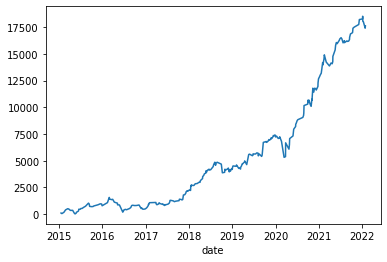

In [20]:
backtest_df.set_index('date', inplace=True)
backtest_df['pnl'].cumsum().plot()

In [ ]:
backtest_df.set_index('date', inplace=True)
backtest_df['pnl'].cumsum().plot()

In [21]:
backtest_df.reset_index(inplace=True)

In [23]:
backtest_df.to_csv('sasta QS trade log.csv')

In [ ]:
def get_equity_curve(df, capital, leverage, lots, lot_size, slippage=0):
    
    quantity = lots*lot_size
    
    df = df.dropna()
    df['capital'] = 0 
    
    for i in range(len(df)):

        if i == 0:
            df['capital'].iloc[i] = (quantity*df['pnl'].iloc[i]*(1-slippage)) + capital
        else:
            if df['capital'].iloc[i-1] <= 0:
                df['capital'].iloc[i-1] = 0
                df['capital'].iloc[i] = 0
            else:
                df['capital'].iloc[i] = (quantity*df['pnl'].iloc[i]*(1-slippage)) + df['capital'].iloc[i-1]

    end_capital = df['capital'].iloc[-1]
    start_date = df['date'].iloc[0]
    end_date = df['date'].iloc[-1]
    
    
    return df, capital, end_capital, start_date, end_date

In [ ]:
def get_cagr(starting_capital, end_capital, no_of_years):    
    return (((end_capital - starting_capital)/ starting_capital)/(no_of_years)) * 100

In [ ]:
def get_mdd(df):
    df['capital_drawdown'] = ((df['capital'] - df['capital'].cummax())/df['capital'].cummax()) * 100
    mdd = df['capital_drawdown'].min()
    return mdd

In [ ]:
def get_calmar(cagr, mdd):
    return cagr/mdd

In [ ]:
def basic_performace_metrics(df):
    
    index = ['no_of_trades', 'no_of_wins', 'win_prct', 'average_profit_per_trade', 'median_of_trade', 'max_profit',
             'min_profit', 'net_profit', 'profit_factor']
    df_metrics = pd.DataFrame(columns=[['value']], index=index)
    
    df_metrics.loc['no_of_trades', 'value'] = len(df)
    df_metrics.loc['no_of_wins', 'value'] = len(df[df['pnl'] > 0])
    df_metrics.loc['win_prct', 'value'] = (len(df[df['pnl'] > 0]) / len(df))*100
    df_metrics.loc['average_profit_per_trade', 'value'] = df['pnl'].mean()
    df_metrics.loc['median_of_trade', 'value'] = df['pnl'].median()
    df_metrics.loc['max_profit','value'] = df['pnl'].max()
    df_metrics.loc['min_profit','value'] = df['pnl'].min()
    gross_profit = df[df['pnl'] > 0]['pnl'].sum()
    gross_loss = df[df['pnl'] < 0]['pnl'].sum()
    df_metrics.loc['net_profit', 'value'] = df['pnl'].sum()
    df_metrics.loc['profit_factor', 'value'] = abs(gross_profit / gross_loss)
    
    return df_metrics

In [ ]:
backtest_df, start_capital, end_capital, start_date, end_date = get_equity_curve(backtest_df, 200000, 1, 1, 25)
no_of_years = ((end_date - start_date).days/365)
cagr = get_cagr(start_capital, end_capital, no_of_years)
mdd = get_mdd(backtest_df)
calmar = get_calmar(cagr, mdd)
df_metrics = basic_performace_metrics(backtest_df)

In [ ]:
cagr, calmar

In [ ]:
df_metrics

In [ ]:
def backtest(df, quantity, lot_size):
    
    

***
# Pushed Below

In [ ]:
DataMining.spot_df.head(10)

In [ ]:
DataMining.spot_df[(DataMining.spot_df['first_max_min_move_H_5_periods_conditions'] == 'min-move_H_5')].head(100)

In [ ]:
DataMining.df_pnl.head(100)

In [ ]:
# Get the equity curve for the desired feature.


In [ ]:
all_features_dict = {}
feature_name = 'rsi'
resampleTime = '15min'
timePeriod = 10
minRsi = 40
maxRsi = 60
input_list = [(resampleTime, 15, timePeriod, minRsi, maxRsi)]

all_features_dict[feature_name] = input_list

time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 15)]

In [ ]:
class KoraReddyDataMining:

    def __init__(self, time_based_entry = None, indicator_dict = None, timebasedentry=True):
        '''
        time_based_entry = [holding period, entry_time, exit_time]},
        indicator_based_entry = {'Indicator_name': [indicator values, resampling_time, entry_condition, exit_condition]}

        features = [{feature_1: [entry_price wrt previous day high]}]
        leg_details = {'leg1': ['CE', strike_price, weekly_expiry, near_expiry]}
        '''
        self.timebasedentry = timebasedentry
        
        if time_based_entry != None:
            self.holding_period = time_based_entry[0]
            self.entry_time = time_based_entry[1]
            self.exit_time = time_based_entry[2]

        self.indicator_dict = indicator_dict

        self.df = pd.read_csv('C:\\Users\\geeta\\Desktop\\Data\\Data\\Intraday\\BANKNIFTY.csv')
        
        self.df['datetime'] = self.df['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        self.df['date'] = self.df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
        self.df['time'] = self.df['time'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time())

        self.df = self.df.drop_duplicates()

        self.df = self.df[self.df['date'] != datetime.date(2021, 2, 24)]
        
        self.tf_to_nbars_map = {'5min':75,
                         '15min':25,
                         '1H':7,
                         'D':1}
        self.feature_handler()
        
        self.positionalPnlTimeBased()

        self.dataminingMetrics()

    def candleType(self, candle_details):

        df = self.df.copy()

        if 'Heikenashi' in candle_details.keys():

            heikenashiPeriod = candle_details['Heikenashi'][0]

            df_HA = pd.concat([df['date'].apply(lambda x: x.date()), ta.ha(df['open'], df['high'], df['low'], df['close'])], axis=1)

    def df_resampling(self, resample_period, base_time=15):

        df = self.df.copy()
        df = self.df.reset_index()
        # df['datetime'] = df['datetime'].apply(lambda x: str(x))
        # df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        df.set_index('datetime', inplace=True)

        resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                           'close': 'last', 'date': 'first', 'time': 'first'}

        df = df.resample(resample_period, base=base_time).apply(resampling_dict)

        df = df.dropna()
        df = df.reset_index()
        return df
    
    def gap(self, resample_period, base_time):
        
        gap_df = self.df_resampling(resample_period, base_time)
        
        condition_list = [(gap_df['open'] >= gap_df['close'].shift()) & (gap_df['open'] <= gap_df['high'].shift()), 
                          (gap_df['open'] < gap_df['close'].shift()) & (gap_df['open'] >= gap_df['low'].shift()), 
                          (gap_df['open'] > gap_df['high'].shift()), 
                          (gap_df['open'] < gap_df['low'].shift())]

        choice_list = [f'gap-up', f'gap-down', f'full-gap-up', f'full-gap-down']
        
        gap_df['gap_conditions'] = np.select(condition_list, choice_list)
        
        self.df = self.df.merge(gap_df[['date', 'gap_conditions']], how='left', on='date')
        self.df = self.df.ffill()
        print(self.df.head())
    
    def rsi(self, resample_period, base_time, lookback, lower_bound, upper_bound):
        
        df_rsi = self.df_resampling(resample_period, base_time)

        df_rsi[f'RSI_{resample_period}_{lookback}'] = talib.RSI(df_rsi['close'], timeperiod=lookback)

        df_rsi[f'RSI_{resample_period}_{lookback}'] = df_rsi[f'RSI_{resample_period}_{lookback}'].shift()

        if resample_period == 'D':
            self.df = self.df.merge(
                df_rsi[['date', f'RSI_{resample_period}_{lookback}']], how='left', on='date')
            self.df = self.df.ffill()

        else:
            self.df = self.df.merge(
                df_rsi[['datetime', f'RSI_{resample_period}_{lookback}']], how='left', on='datetime')
            self.df = self.df.ffill()

        # print('rsi_df: ', self.df.tail())

        condition_list = [(self.df[f'RSI_{resample_period}_{lookback}'] >= upper_bound), 
                          ((self.df[f'RSI_{resample_period}_{lookback}'] < upper_bound) & (self.df[f'RSI_{resample_period}_{lookback}'] > lower_bound)), 
                          (self.df[f'RSI_{resample_period}_{lookback}'] <= lower_bound)]
        
        choice_list = [f'RSI_{resample_period}_{lookback}>{upper_bound}', 
                       f'{lower_bound}<RSI_{resample_period}_{lookback}<{upper_bound}', 
                       f'RSI_{resample_period}_{lookback}<{lower_bound}']
        
        self.df[f'RSI_{resample_period}_{lookback}_{lower_bound}_{upper_bound}_conditions'] = np.select(condition_list, choice_list)
    
    def high_low_close(self, resample_period, base_time, lookback):
        
        df_high_low = self.df_resampling(resample_period, base_time)
        
        df_high_low[f'close_high_{lookback}'] = df_high_low['close'].rolling(window = lookback).max()
        df_high_low[f'close_low_{lookback}'] = df_high_low['close'].rolling(window = lookback).min()
        
        df_high_low[f'close_high_{lookback}'] = df_high_low[f'close_high_{lookback}'].shift()
        df_high_low[f'close_low_{lookback}'] = df_high_low[f'close_low_{lookback}'].shift()
        
        if resample_period == 'D':
            self.df = self.df.merge(
                df_high_low[['date', f'close_high_{lookback}', f'close_low_{lookback}']], how='left', on='date')
            self.df = self.df.ffill()

        else:
            self.df = self.df.merge(
                df_high_low[['datetime', f'close_high_{lookback}', f'close_low_{lookback}']], how='left', on='datetime')
            self.df = self.df.ffill()
        
        condition_list = [self.df['close'] >= self.df[f'close_high_{lookback}'], 
                          self.df['close'] <= self.df[f'close_low_{lookback}'], 
                          (self.df['close'] < self.df[f'close_high_{lookback}']) & (self.df['close'] > self.df[f'close_low_{lookback}'])]
        
        choice_list = [f'{lookback}_high', f'{lookback}_low', f'between_{lookback}_high_low']
        
        self.df[f'{resample_period}_{lookback}_period_high_low_conditions'] = np.select(condition_list, choice_list)
    
    def max_move(self, resample_period, base_time, lookback):
        
        df_max_move = self.df_resampling(resample_period, base_time)
        
        df_max_move[f'{lookback}_%move'] = (df_max_move['close'] - df_max_move['close'].shift())/df_max_move['close'].shift()
        df_max_move[f'{lookback}_abs_%move'] = abs(df_max_move[f'{lookback}_%move'])
        
        conditions = [(df_max_move[f'{lookback}_abs_%move'] == df_max_move[f'{lookback}_abs_%move'].rolling(window=lookback).max()) & (df_max_move[f'{lookback}_%move']<0),
                      (df_max_move[f'{lookback}_abs_%move'] == df_max_move[f'{lookback}_abs_%move'].rolling(window=lookback).max()) & (df_max_move[f'{lookback}_%move']>0),
                      (df_max_move[f'{lookback}_abs_%move'] < df_max_move[f'{lookback}_abs_%move'].rolling(window=lookback).max())]
        
        choices = [f'{lookback}_max_down_move', f'{lookback}_max_up_move', f'{lookback}_regular_move']
        
        df_max_move[f'max_up_down_move_{lookback}_conditions'] = np.select(conditions, choices)
        
        df_max_move[f'max_up_down_move_{lookback}_conditions'] = df_max_move[f'max_up_down_move_{lookback}_conditions'].shift()
        
        if resample_period == 'D':
            self.df = self.df.merge(df_max_move[['date', f'max_up_down_move_{lookback}_conditions']], how='left', on='date')
            self.df = self.df.ffill()

        else:
            self.df = self.df.merge(df_max_move[['datetime', f'max_up_down_move_{lookback}_conditions']], how='left', on='datetime')
            self.df = self.df.ffill()
    
    def dow(self):
        
        self.df['day_of_week_conditions'] = self.df['date'].apply(lambda x: x.strftime("%A"))
    
    def log_volatility(self, resample_period, base_time, lookback):
        
        annualize_factor = self.tf_to_nbars_map[resample_period] * 252
        
        df_vol = self.df_resampling(resample_period, base_time)
        
        df_vol[f'std_{resample_period}_{lookback}'] = np.log(df_vol['close']/df_vol['close'].shift()).rolling(window = window).std() * math.sqrt(annualize_factor) * 100    
        df_vol[f'std_{resample_period}_{lookback}'] = df_vol[f'std_{resample_period}_{lookback}'].shift()
        
        if resample_period == 'D':
            self.df = self.df.merge(df_vol[['date', f'std_{resample_period}_{lookback}']], how='left', on='date')
            self.df = self.df.ffill()

        else:
            self.df = self.df.merge(df_vol[['datetime', f'std_{resample_period}_{lookback}']], how='left', on='datetime')
            self.df = self.df.ffill()
    
    def get_vol_condition(self, vol_compare):
        
        condition1 = vol_compare[1]
        condition2 = vol_compare[2]
        
        
    def feature_handler(self):

        if 'rsi' in self.indicator_dict:

            resample_period = self.indicator_dict['rsi'][0]
            base_time = self.indicator_dict['rsi'][1]
            indicator_timeperiod = self.indicator_dict['rsi'][2]
            first_value = self.indicator_dict['rsi'][3] # 20
            second_value = self.indicator_dict['rsi'][4] # 80    

            self.rsi(resample_period, base_time, indicator_timeperiod, first_value, second_value)

        if 'gap' in self.indicator_dict:

            resample_period = self.indicator_dict['gap'][0]
            base_time = self.indicator_dict['gap'][1]

            self.gap(resample_period, base_time)

        if 'high-low-close' in self.indicator_dict:

            resample_period = self.indicator_dict['high-low-close'][0]
            base_time = self.indicator_dict['high-low-close'][1]
            indicator_timeperiod = self.indicator_dict['high-low-close'][2]

            self.high_low_close(resample_period, base_time, indicator_timeperiod)

        if 'max_move' in self.indicator_dict:

            resample_period = self.indicator_dict['max_move'][0]
            base_time = self.indicator_dict['max_move'][1]
            indicator_timeperiod = self.indicator_dict['max_move'][2]

            self.max_move(resample_period, base_time, indicator_timeperiod)

#         if 'vol_compare' in self.indicator_dict:

#             vol_condition1 = self.indicator_dict['vol_compare'][1]
#             vol_name = vol_condition1[0]
#             resample_period1 = vol_condition1[1]
#             base_time1 = vol_condition1[2]
#             indicator_timeperiod1 = vol_condition1[3]
            
            
            
            
#             vol_condition2 = self.indicator_dict['vol_compare'][2]
#             resample_period2 = vol_condition2[0]
#             base_time2 = vol_condition2[1]
#             indicator_timeperiod2 = vol_condition2[2]

        self.df = self.df.dropna()


    def everydayPnlTimeBased(self):

        df = self.df.copy()

        dates_list = list(df['date'].unique())

        df_pnl = pd.DataFrame()

        for _ in range(len(dates_list) - self.holding_period):
            entry_datetime = datetime.datetime.combine(dates_list[_], self.entry_time)
            exit_datetime = datetime.datetime.combine(dates_list[_+self.holding_period], self.exit_time)

            entry_row = df[df['datetime'] == entry_datetime]
            entry_row['days'] = entry_row['datetime'].apply(lambda x: x.strftime("%A"))
            column_names = entry_row.columns

            entry_columns_name_dict = {}
            for col_name in column_names:
                entry_columns_name_dict[col_name] = 'entry_' + col_name

            entry_row = entry_row.rename(columns = entry_columns_name_dict)
            entry_row = entry_row.reset_index(drop = True)

            exit_row = df[df['datetime'] == exit_datetime]
            exit_row['days'] = exit_row['datetime'].apply(lambda x: x.strftime("%A"))
            column_names = exit_row.columns

            exit_columns_name_dict = {}
            for col_name in column_names:
                exit_columns_name_dict[col_name] = 'exit_' + col_name

            exit_row = exit_row.rename(columns = exit_columns_name_dict)
            exit_row = exit_row.reset_index(drop = True)

            temp_row = pd.concat([entry_row, exit_row], axis= 1)
            df_pnl = df_pnl.append(temp_row, ignore_index=True)

        df_pnl = df_pnl.iloc[:-1]
        df_pnl['pnl'] = df_pnl['exit_close'] - df_pnl['entry_close']
        return df_pnl
        
    def positionalPnlTimeBased(self):

        df = self.df.copy()

        dates_list = list(df['date'].unique())
        
#         print(dates_list)
        df_pnl = pd.DataFrame()

        if self.holding_period == 0:

            for _ in range(0, (len(dates_list) - self.holding_period), 1):
                entry_datetime = datetime.datetime.combine(dates_list[_], self.entry_time)
                exit_datetime = datetime.datetime.combine(dates_list[_+self.holding_period], self.exit_time)

                entry_row = df[df['datetime'] == entry_datetime]
#                 print(entry_row)
#                 print()
                # if (len(entry_row) > 1):
                #     print('entry_row: ', entry_row)

                entry_row['days'] = entry_row['datetime'].apply(lambda x: x.strftime("%A"))
                column_names = entry_row.columns

                entry_columns_name_dict = {}
                for col_name in column_names:
                    entry_columns_name_dict[col_name] = 'entry_' + col_name

                entry_row = entry_row.rename(columns = entry_columns_name_dict)
                entry_row = entry_row.reset_index(drop = True)

                exit_row = df[df['datetime'] == exit_datetime]

                # if (len(exit_row) > 1):
                #     print('exit_row: ', exit_row)

                exit_row['days'] = exit_row['datetime'].apply(lambda x: x.strftime("%A"))
                column_names = exit_row.columns

                exit_columns_name_dict = {}
                for col_name in column_names:
                    exit_columns_name_dict[col_name] = 'exit_' + col_name

                exit_row = exit_row.rename(columns = exit_columns_name_dict)
                exit_row = exit_row.reset_index(drop = True)

                exit_row = exit_row[['exit_time', 'exit_datetime', 'exit_close']]

                temp_row = pd.concat([entry_row, exit_row], axis= 1)

                # if len(temp_row[temp_row['entry_datetime'].isna()]) > 0:
                #     print('temp_row: ', pd.DataFrame(temp_row))

                df_pnl = df_pnl.append(temp_row, ignore_index=True)

            df_pnl = df_pnl.iloc[:-1]
            df_pnl['pnl'] = df_pnl['exit_close'] - df_pnl['entry_close']

            df_pnl['entry_exit_conditions'] = str(self.entry_time.strftime("%H:%M")) + '-' + str(self.exit_time.strftime("%H:%M")) + '-' + str(self.holding_period)

        elif self.holding_period != 0:

            for _ in range(0, (len(dates_list) - self.holding_period), self.holding_period):
                entry_datetime = datetime.datetime.combine(dates_list[_], self.entry_time)
                exit_datetime = datetime.datetime.combine(dates_list[_+self.holding_period], self.exit_time)

                entry_row = df[df['datetime'] == entry_datetime]

                # if (len(entry_row) > 1):
                #     print('entry_row: ', entry_row)

                entry_row['days'] = entry_row['datetime'].apply(lambda x: x.strftime("%A"))
                column_names = entry_row.columns

                entry_columns_name_dict = {}
                for col_name in column_names:
                    entry_columns_name_dict[col_name] = 'entry_' + col_name

                entry_row = entry_row.rename(columns = entry_columns_name_dict)
                entry_row = entry_row.reset_index(drop = True)

                exit_row = df[df['datetime'] == exit_datetime]

                # if (len(exit_row) > 1):
                #     print('exit_row: ', exit_row)

                exit_row['days'] = exit_row['datetime'].apply(lambda x: x.strftime("%A"))
                column_names = exit_row.columns

                exit_columns_name_dict = {}
                for col_name in column_names:
                    exit_columns_name_dict[col_name] = 'exit_' + col_name

                exit_row = exit_row.rename(columns = exit_columns_name_dict)
                exit_row = exit_row.reset_index(drop = True)

                exit_row = exit_row[['exit_time', 'exit_datetime', 'exit_close']]

                temp_row = pd.concat([entry_row, exit_row], axis= 1)

                # if len(temp_row[temp_row['entry_datetime'].isna()]) > 0:
                #     print('temp_row: ', pd.DataFrame(temp_row))

                df_pnl = df_pnl.append(temp_row, ignore_index=True)

            df_pnl = df_pnl.iloc[:-1]
            df_pnl['pnl'] = df_pnl['exit_close'] - df_pnl['entry_close']

            df_pnl['entry_exit_conditions'] = str(self.entry_time.strftime("%H:%M")) + '-' + str(self.exit_time.strftime("%H:%M")) + '-' + str(self.holding_period)

        return df_pnl


    def dataminingMetrics(self):

        df_pnl = self.positionalPnlTimeBased()

        df_pnl = df_pnl.dropna()

        # (9:30-14:30-0-RSI<40), (14:00-9:45-1-RSI>60)
        # entryTime-exitTime-holdingPeriod-conditions
        self.df_pnl_check = df_pnl
        column_name_list = df_pnl.columns

        condition_column_list = [i for i in column_name_list if 'conditions' in i.split('_')[-1]]

        # print(condition_column_list)

        self.strategy_description = 'datamining-table-' + '-'.join(condition_column_list)

        # print('self.strategy_description: ', self.strategy_description)

        df_pnl['strategy_combination'] = df_pnl[condition_column_list].apply(lambda row: '-'.join(row.values.astype(str)), axis = 1)

        unique_strategies = df_pnl['strategy_combination'].unique()

        columns = ['action', 'number_of_trades', 'win_percentage', 'average', 'median', 'max', 'min', 'average_profit', 'std_dev',
                   't-test', 'net_profit', 'p-value', 'gross_profit', 'gross_loss', 'profit_factor', 'outlier_adjusted_profit_factor']

        self.datamining_table = pd.DataFrame(columns=columns, index=unique_strategies)

        for strategy in unique_strategies:

            temp_return_data = df_pnl.copy()

            self.datamining_table['average'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].mean(), 2)

            if self.datamining_table['average'].loc[strategy] < 0:
                temp_return_data['pnl'] = -1*temp_return_data['pnl']
                self.datamining_table['action'].loc[strategy] = 'short'
            else:
                self.datamining_table['action'].loc[strategy] = 'long'

            self.datamining_table['number_of_trades'].loc[strategy] = len(temp_return_data[temp_return_data['strategy_combination'] == strategy])

            self.datamining_table['win_percentage'].loc[strategy] = round(len(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)])*100 / len(temp_return_data[temp_return_data['strategy_combination'] == strategy]), 2)

            self.datamining_table['average'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].mean(), 2)

            self.datamining_table['median'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].median(), 2)

            self.datamining_table['max'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].max(), 2)

            self.datamining_table['min'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].min(), 2)

            self.datamining_table['average_profit'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)]['pnl'].mean(), 2)

            self.datamining_table['std_dev'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].std(), 2)

            self.datamining_table['net_profit'].loc[strategy] = round(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'].sum(), 2)

            self.datamining_table['t-test'].loc[strategy] = round(stats.ttest_1samp(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'], 0)[0], 2)

            self.datamining_table['p-value'].loc[strategy] = round((stats.ttest_1samp(temp_return_data[temp_return_data['strategy_combination'] == strategy]['pnl'], 0)[1])/2, 2)

            self.datamining_table['gross_profit'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] > 0)]['pnl'].sum(), 2)

            self.datamining_table['gross_loss'].loc[strategy] = round(temp_return_data[(temp_return_data['strategy_combination'] == strategy) & (temp_return_data['pnl'] < 0)]['pnl'].sum(), 2)

        self.datamining_table['profit_factor'] = abs(self.datamining_table['gross_profit'] / self.datamining_table['gross_loss'])

        self.datamining_table['profit_factor'] = self.datamining_table['profit_factor'].apply(lambda x: round(x, 2))

        self.datamining_table['outlier_adjusted_profit_factor'] = abs((self.datamining_table['gross_profit']
                                                                   - self.datamining_table['max']) / self.datamining_table['gross_loss'])

        self.datamining_table['outlier_adjusted_profit_factor'] = self.datamining_table['outlier_adjusted_profit_factor'].apply(lambda x: round(x, 2))

        self.datamining_table.to_pickle(f'C:\\Users\\geeta\\Vihan_YashRaj_backtest\\{self.strategy_description}_ET_{str(self.entry_time.hour)}_{str(self.entry_time.minute)}_{str(self.exit_time.hour)}_EXT_{str(self.exit_time.minute)}_{str(self.holding_period)}.pkl')


In [ ]:
df_inputs = pd.DataFrame()
resampleTime = '15min'
timePeriod = 10
minRsi = 40
maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['rsi'], 'indicator_inputs': [[resampleTime, 15, timePeriod, minRsi, maxRsi]]})
time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = 'D'
# timePeriod = 10
# minRsi = 40
# maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['gap'], 'indicator_inputs': [[resampleTime, 15]]})
time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = 'D'
timePeriod = 20
# minRsi = 40
# maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['high-low-close'], 'indicator_inputs': [[resampleTime, 15, timePeriod]]})
time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = '1H'
timePeriod = 20
# minRsi = 40
# maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['high-low-close'], 'indicator_inputs': [[resampleTime, 15, timePeriod]]})
time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = '1H'
timePeriod = 20
# minRsi = 40
# maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['high-low-close'], 'indicator_inputs': [[resampleTime, 15, timePeriod]]})
time_based_entries = [0, datetime.time(14, 16), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = '1H'
timePeriod = 10
# minRsi = 40
# maxRsi = 60
df_inputs = pd.DataFrame({'indicator_name': ['max_move'], 'indicator_inputs': [[resampleTime, 15, timePeriod]]})
time_based_entries = [0, datetime.time(10, 20), datetime.time(15, 15)]

In [ ]:
df_inputs = pd.DataFrame()
resampleTime = 'D'
df_inputs = pd.DataFrame({'indicator_name': ['multiple_days'], 'indicator_inputs': [[resampleTime, 15]]})

In [ ]:
indicator_dict = {}
indicator_dict['gap'] = ['D', 15]
time_based_entries = [0, datetime.time(9, 20), datetime.time(15, 25)]

In [ ]:
K = KoraReddyDataMining(time_based_entry = time_based_entries, indicator_dict = indicator_dict)

In [ ]:
DataMining.df_pnl

In [ ]:
K.df_pnl_check

In [ ]:
K.datamining_table

In [ ]:
K.datamining_table

In [ ]:
df = pd.read_csv('C:\\Users\\geeta\\Desktop\\Data\\Data\\Intraday\\BANKNIFTY.csv')

In [ ]:
df.head()

In [ ]:
def sumn(a, b):
    
    return a+b
def add2nums(a, b, sum2nums):
    
    return sum2nums(a, b)
add2nums(2, 3, sumn)

In [ ]:
class Indi:
    a = 1
    b = 2
    c = None
    
    @staticmethod
    def set_c(n):
        Indi.c = n

In [ ]:
class Data:
    
    @staticmethod
    def print_a():
        print(Indi.a)
    def print_b():
        print(Indi.b)
    def print_c(n):
        Indi.set_c(n)
        print(Indi.c)

In [ ]:
Data.print_c(10)

In [ ]:
df = pd.read_csv('C:\\Users\\geeta\\Desktop\\Data\\Data\\Intraday\\BANKNIFTY.csv')
df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
df['time'] = df['time'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time())
df = df.drop_duplicates()

In [ ]:
df_copy = df.copy()
df.set_index('datetime', inplace=True)

resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                   'close': 'last', 'date': 'first', 'time': 'first'}

df = df.resample('D').apply(resampling_dict)
df = df.dropna()
df = df.reset_index()
df.head()

In [ ]:
df['day_of_week'] = df['date'].apply(lambda x: x.strftime("%A"))

In [ ]:
df = df[(df['day_of_week']!='Saturday') & (df['day_of_week']!='Sunday')]

In [ ]:
df.to_pickle('banknifty_spot_data.pkl')

In [ ]:
df = df.merge(df_expiry, on='date', how='left')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.tail()

In [ ]:
resample_period = 'D'
lookback = 5
df[f'max_min_move_{resample_period}_{lookback}_periods'] = np.where(abs(np.log(df['close']/df['close'].shift())).rolling(window = lookback).max() == abs(np.log(df['close']/df['close'].shift())), 'max', '-')
        
df[f'max_min_move_{resample_period}_{lookback}_periods'] = np.where((df[f'max_min_move_{resample_period}_{lookback}_periods'] == 'max') &
                                                (np.log(df['close']/df['close'].shift()) < 0),
                                                f'min-move_{resample_period}_{lookback}',
                                                np.where((df[f'max_min_move_{resample_period}_{lookback}_periods'] == 'max') & (np.log(df['close']/df['close'].shift()) > 0),
                                                f'max-move_{resample_period}_{lookback}', '-'))

In [ ]:
df.tail(100)

In [ ]:
if resample_period != 'D':
    df['first_min_move'] = np.where((df['opex'].shift()=='opex')&(df['opex']!='opex'), 1, None)
    df['first_min_move'] = np.where(df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'min-move_{resample_period}_{lookback}', f'min-move_{resample_period}_{lookback}', df['first_min_move'])
    df.loc[:,'first_min_move'] = df.loc[:,'first_min_move'].ffill()
    df['first_min_move'] = np.where((df['first_min_move'].shift()==1)&(df['first_min_move']==f'min-move_{resample_period}_{lookback}'),f'min-move_{resample_period}_{lookback}','-') 

else:
    df['first_max_move'] = np.where((df['opex'].shift()=='opex')&(df['opex']!='opex'), 1, None)
    df['first_max_move'] = np.where(df[f'max_min_move_{resample_period}_{lookback}_periods'] == f'max-move_{resample_period}_{lookback}', f'max-move_{resample_period}_{lookback}', df['first_max_move'])
    df.loc[:,'first_max_move'] = df.loc[:,'first_max_move'].ffill()
    conditions = [(df['first_max_move'] == f'max-move_{resample_period}_{lookback}') & (df['opex'].shift()=='opex'),
                  (df['first_max_move'] == f'max-move_{resample_period}_{lookback}') & (df['first_max_move'].shift()==1)]
    choices = [f'max-move_{resample_period}_{lookback}', f'max-move_{resample_period}_{lookback}']
    
    df['first_max_move'] = np.select(conditions, choices)
    
    df['first_max_move'] = np.where(df['first_max_move'] == '0', '-', df['first_max_move'])

In [ ]:
df.tail(100)

In [ ]:
times = df['time'].unique()

In [ ]:
times.sort()

In [ ]:
times = [i for i in times if i<=datetime.time(15, 0)]

In [ ]:
times.remove(datetime.time(9, 26))
times.remove( datetime.time(9, 35))

In [ ]:
times

In [ ]:
temp.head()

In [ ]:
dates_list = list(df['date'].unique())

In [ ]:
dates_list

In [ ]:
holding_period = 2
positional_dates_list = []
for _ in range(0, len(dates_list), holding_period):
    positional_dates_list.append(dates_list[_])

positional_dates_list    

In [ ]:
positional_entry_dates_list = positional_dates_list
positional_exit_dates_list = positional_dates_list[1:]
positional_exit_dates_list.append(np.nan)

In [ ]:
df_positional = pd.DataFrame({'entry_date': positional_entry_dates_list})
df_positional['exit_date'] = positional_exit_dates_list


In [ ]:
entry_time = datetime.time(9, 25)
exit_time = datetime.time(9, 20)
df_positional['entry_time'] = entry_time
df_positional['exit_time'] = exit_time
df_positional.dropna(inplace=True)
df_positional['entry_datetime'] = df_positional[['entry_date', 'entry_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['entry_date'], row['entry_time']), axis = 1)
df_positional['exit_datetime'] = df_positional[['exit_date', 'exit_time']].apply(lambda row: 
                                                datetime.datetime.combine(row['exit_date'], row['exit_time']), axis = 1)
df_positional                                               

In [ ]:
df_positional.iloc[0:0]

In [ ]:
columns = [i for i in df_positional.columns if i.split('_')[-1] == 'date']

In [ ]:
columns

In [ ]:
str(datetime.time(9, 15))

In [ ]:
times_list = [i for i in df['time'].unique() i<=datetime.time(15,0)]

In [ ]:
times_list.remove(datetime.time(9,35))

In [ ]:
resample_period='1H'
lookback = 5
for time in times_list:
    temp = df[df['time']==time].copy()

    temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] = np.where(abs(np.log(temp['close']/temp['open'])).rolling(window = lookback).max() == abs(np.log(temp['close']/temp['open'])), 'max', '')
    temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] = np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] == 'max') & (np.log(temp['close']/temp['open']) < 0), f'min-move_{resample_period}_{lookback}', np.where((temp[f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}'] == 'max') & (np.log(temp['close']/temp['open']) > 0), f'max-move_{resample_period}_{lookback}', ''))

    df = df.merge(temp[['datetime', f'max_min_move_{resample_period}_{lookback}_periods_{str(time)}']], on='datetime', how='left')
    df.fillna('', inplace=True)

column_list = [i for i in df.columns if i.split(resample_period)[0] == 'max_min_move_']
df[f'max_min_{resample_period}_{lookback}'] = df[column_list].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)
df = df.drop(column_list, axis = 1)
df[f'max_min_{resample_period}_{lookback}'] = np.where(df[f'max_min_{resample_period}_{lookback}'] == '', '-', df[f'max_min_{resample_period}_{lookback}'])
df.tail(100)

In [ ]:
df.head(100)

In [ ]:
df_expiry = pd.read_pickle('banknifty_front_expiry.pkl')

In [ ]:
df_expiry

In [ ]:
conditions = [df_expiry['date'] == df_expiry['expiry_date'],
     df_expiry['date'].shift(-1) == df_expiry['expiry_date'],
     (df_expiry['date'].shift(-2) == df_expiry['expiry_date']),
     (df_expiry['date'].shift(-3) == df_expiry['expiry_date']),
     (df_expiry['date'].shift(-4) == df_expiry['expiry_date'])]

choices = ['opex', 'opex1', 'opex2', 'opex3', 'opex4']

df_expiry['opex'] = np.select(conditions, choices)

In [ ]:
df_expiry.tail()

In [ ]:
max_min_df[f'max_min_move_{resample_period}_{period}_periods'] = np.where(abs(np.log(max_min_df['close']/max_min_df['close'].shift())).rolling(window = lookback).max() == abs(np.log(max_min_df['close']/max_min_df['close'].shift())), 'max', '-')
        
max_min_df[f'max_min_move_{resample_period}_{period}_periods'] = np.where((max_min_df[f'max_min_move_{period}_days'] == 'max') &
                                                (np.log(max_min_df['close']/max_min_df['close'].shift()) < 0),
                                                f'min-move_{resample_period}_{lookback}',
                                                np.where((max_min_df[f'max_min_move_{period}_days'] == 'max') & (np.log(max_min_df['close']/max_min_df['close'].shift()) > 0),
                                                f'max-move_{resample_period}_{lookback}', '-'))

In [ ]:
df = pd.DataFrame({'a':['a', 'b', 'a', 'c', 'd', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'a', 'b'], 'b':[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]})

In [ ]:
df

In [ ]:
def counta(df):

    df = pd.DataFrame(df)
    df.columns = ['a']
    
    df['count'] = np.where(df['a']=='a', 1, 0)
    df['count'] = df['count'].cumsum()
    return df['count']
    
    
    

In [ ]:
df['counta'] = np.where(df['a'] == 'a', 1, 0)
df['counta'] = df.groupby('b')['counta'].apply(lambda x: x.cumsum())

In [ ]:
df

In [ ]:
df = pd.read_pickle('banknifty_spot_data.pkl')

In [ ]:
df.head()

In [ ]:
df_copy = df.copy()
df.set_index('datetime', inplace=True)

resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                   'close': 'last', 'date': 'first', 'time': 'first'}

df = df.resample('1H').apply(resampling_dict)
df = df.dropna()
df = df.reset_index()
df.head()

In [ ]:
df['orh'] = np.where(df['time']==datetime.time(9, 15), df['high'], np.nan)
df['orl'] = np.where(df['time']==datetime.time(9, 15), df['low'], np.nan)
df.head(20)

In [ ]:
df = df.ffill()
df['datetime'] = np.where(df['time'] == datetime.time(9, 15), df[['date', 'time']].apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis = 1), df['datetime'])
df.head(20)

In [ ]:
df_copy = df_copy.merge(df[['datetime', 'orh', 'orl']], on='datetime', how='left')
df_copy.head(500)

In [ ]:
df_copy = df_copy.ffill()
df_copy.head(500)

In [ ]:
df = pd.read_pickle('banknifty_spot_data.pkl')

In [ ]:

def resample_df(df, period, expiry=False, opex=False):

    df.set_index('datetime', inplace=True)

    if expiry:
        resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                       'close': 'last', 'date': 'first', 'time': 'first', 'expiry_date':'first'}
    elif opex:
        resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                       'close': 'last', 'date': 'first', 'time': 'first', 'opex':'first'}
    else:
        resampling_dict = {'open': 'first', 'high': 'max', 'low': 'min',
                       'close': 'last', 'date': 'first', 'time': 'first'}

    df = df.resample(period).apply(resampling_dict)
    df = df.dropna()
    df = df.reset_index()

    return df

In [ ]:

def log_volatility(df, params, factor):

    resample_period = params[0]
    lookback = params[1]*factor[resample_period]
    annualize = factor[resample_period]*252

    vol_df = df[['date', 'datetime', 'time', 'open', 'high', 'low', 'close']].copy()
    vol_df = resample_df(vol_df, resample_period)

    vol_df[f'log_vol_{resample_period}_{lookback}'] = np.log(vol_df['close']/vol_df['close'].shift()).rolling(window = lookback).std() * math.sqrt(annualize) * 100

    vol_df[f'log_vol_{resample_period}_{lookback}'] = vol_df[f'log_vol_{resample_period}_{lookback}'].shift()

    if resample_period == 'D':
        df = df.merge(
            vol_df[['date', f'log_vol_{resample_period}_{lookback}']], how='left', on='date')
        df = df.ffill()
    else:
        df = df.merge(
            vol_df[['datetime', f'log_vol_{resample_period}_{lookback}']], how='left', on='datetime')
        df = df.ffill()

    return df

In [ ]:
factor = {'5Min':75, '1H':7, 'D':1}
params1 = ['D', 20]
params2 = ['1H', 20]
params3 = ['5Min', 20]
params = [params1, params2, params3]



df = log_volatility(df, params1, factor)
df = log_volatility(df, params2, factor)
df = log_volatility(df, params3, factor)

df['diff'] = df['log_vol_D_20']-df['log_vol_5Min_1500']
df['diff_ma'] = df['diff'].rolling(window = 5000).mean()
# df.set_index('datetime', inplace=True)
# df[['diff', 'diff_ma']].iloc[-100000:].plot()


In [ ]:
import math

In [ ]:
df[['diff', 'diff_ma']].plot()

In [ ]:
df['diff_diff_ma'] = (df['diff'] - df['diff_ma'])


In [ ]:
df['diff_diff_ma'] = np.where(df['diff_diff_ma']>df['diff_diff_ma'].shift(), 1, -1)
df['diff_diff_ma'] = df['diff_diff_ma'].rolling(window = 500).sum()

In [ ]:
df['diff_diff_ma'] = df['diff_diff_ma'].rolling(window = 5000).apply(pctrank)

In [ ]:
df.set_index('datetime', inplace=True)

In [ ]:
df.iloc[201500:203000]

In [ ]:
df[['log_vol_D_20', 'log_vol_5Min_1500']].iloc[460000:503000].plot()

In [ ]:
df['diff_diff_ma'].iloc[201500:203000].plot()

In [ ]:
def pctrank(x):
    n = len(x)
    temp = x.argsort()
    ranks = np.empty(n)
    ranks[temp] = (np.arange(n) + 1) / n
    return ranks[-1]

In [ ]:
df = pd.DataFrame({'a':[1, 2, 3, 2, 3, 4, 1, 2, 10, 8, 5, 6, 19, 20, 21, 0, 3, 4, 15, 12, 18, 11, 12, 9, 8, 7, 5, 2, 14, 13, 21]})

In [ ]:
df['pecent_rank_a'] = df['a'].rolling(window = 7).apply(pctrank)

In [ ]:
a = np.array([1, 2, 3, 2, 3, 4, 1])
x = a.argsort()

In [ ]:
a[x]

In [ ]:
x

In [ ]:
rank = np.empty(7)
# (np.arange(7) + 1)/7

In [ ]:
rank

In [ ]:
rank[x] 

In [ ]:
np.empty(6)

In [ ]:
df

In [ ]:
'''
# get daily A level by just providing timeframe = daily, Atr = lookback, prem_mult, open_range

# ACD level params = {'daily':,
                      'hourly':,
                      'five_min':,
                      'weekly':,
                      'monthly':,
                      }

Indicator is the score at the time frame level.

n-day sum score (up-score, down-score, net-score)

score_indicator = {'level_params',
                   'score_params'}

'''

In [ ]:
import json
import datetime

In [ ]:
file = open('check_json.json', 'r')
time = json.loads(file.read())

In [ ]:
type(time['check'])

In [ ]:
time

In [ ]:
time = "9:45"

In [ ]:
time = datetime.datetime.strptime(time, '%H:%M').time()

In [ ]:
time

In [ ]:
datetime.time(9, 45)